#Object Detection Algorithm

In [1]:
!git clone https://github.com/tensorflow/tpu/

Cloning into 'tpu'...
remote: Enumerating objects: 10548, done.
remote: Counting objects: 100% (750/750), done.
remote: Compressing objects: 100% (476/476), done.
remote: Total 10548 (delta 370), reused 520 (delta 260), pack-reused 9798
Receiving objects: 100% (10548/10548), 45.54 MiB | 28.77 MiB/s, done.
Resolving deltas: 100% (7408/7408), done.


In [2]:
from IPython import display
from PIL import Image
import numpy as np
import pandas as pd
%tensorflow_version 1.x
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils

TensorFlow 1.x selected.


In [3]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

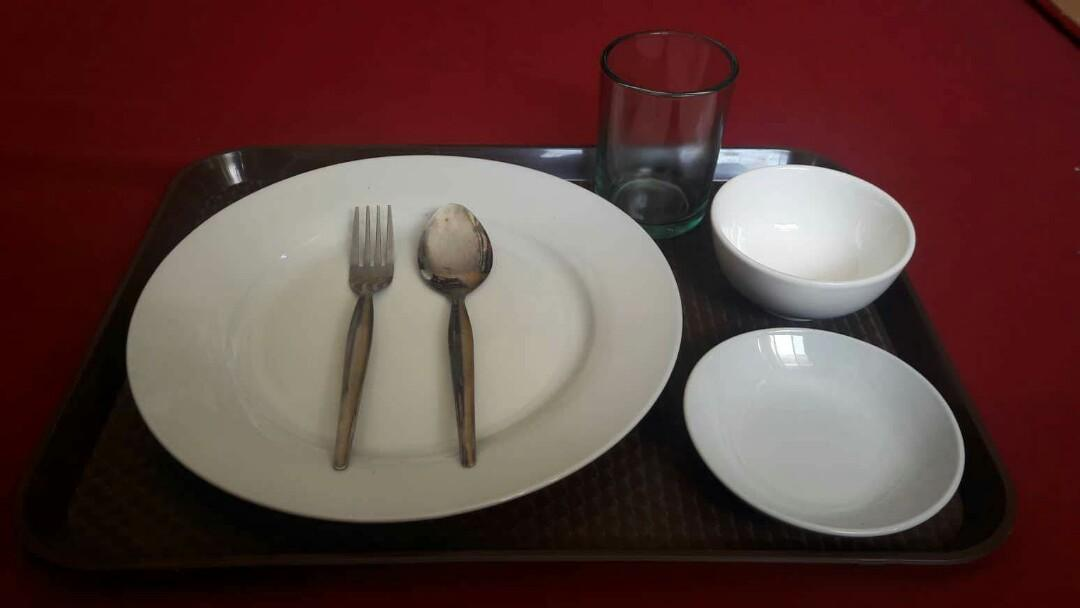

In [4]:
image_path = 'test3.jpg' # % (i)

with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])
  
image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))

In [5]:
use_tpu = True #@param {type:"boolean"}
if use_tpu:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

TPU address is grpc://10.117.223.42:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 12326592621727357218),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11353203492358794409),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 4863964280395979233),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 6440994180703221325),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 11185198838726157079),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 5838253833899745932),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 13925069235983274745),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 16230300637594042009),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 1342845174

In [6]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from gs://cloud-tpu-checkpoints/mask-rcnn/1555659850/variables/variables


In [7]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],feed_dict={'Placeholder:0': np_image_string})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

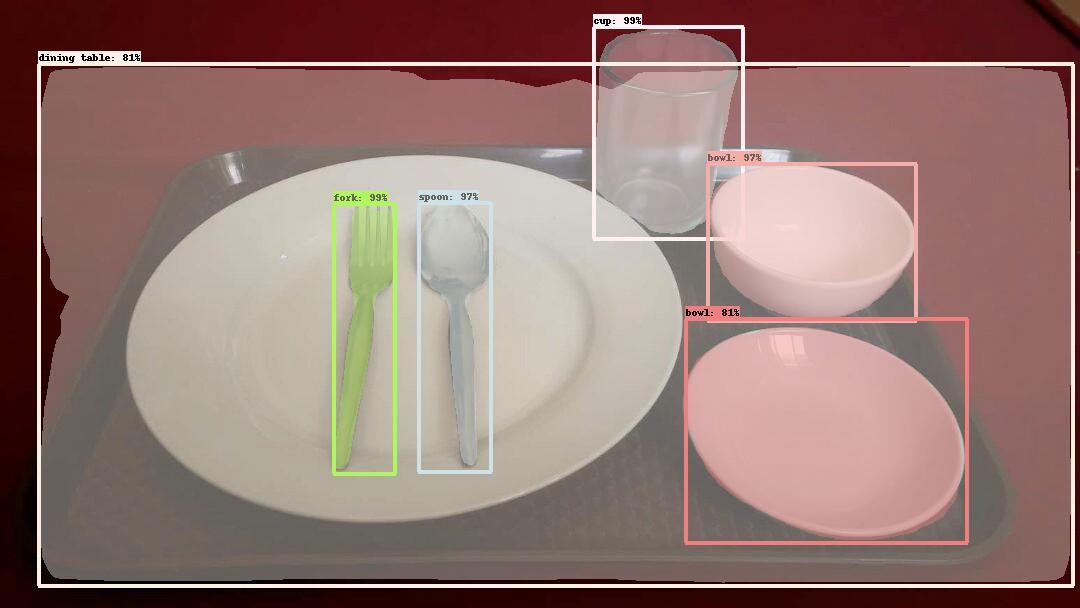

In [8]:
max_boxes_to_draw = 10   #@param {type:"integer"}
min_score_thresh = 0.61    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))

In [9]:
Object_name = []
for i in range(len(detection_classes)):
  Object_name.append(ID_MAPPING.get(detection_classes[i]))

In [10]:
ymin = np.array([i[0] for i in ymin])
ymax = np.array([i[0] for i in ymax])
xmin = np.array([i[0] for i in xmin])
xmax = np.array([i[0] for i in xmax])

In [11]:
d1 = pd.DataFrame(data={'Y_min' : ymin,'Y_max' : ymax,'X_min' : xmin,'X_max' : xmax, 'Object_Class' : detection_classes, 'Object_name' : Object_name})
d1

,Y_min,Y_max,X_min,X_max,Object_Class,Object_name
0,204.024658,473.810822,333.426880,395.522095,48,fork
1,27.450642,238.625015,593.952759,743.837036,47,cup
2,164.168320,320.764618,707.289856,916.267883,51,bowl
3,203.724503,471.921936,418.144073,491.759247,50,spoon
4,64.319199,585.063049,38.127625,1073.494751,67,dining table
5,319.155731,542.598816,685.914062,967.848938,51,bowl
6,206.108704,466.729156,415.192932,493.913727,48,fork
7,200.164490,469.293243,331.425537,396.851044,50,spoon
8,162.156036,316.406891,706.431213,919.573486,47,cup
9,185.024902,473.258575,328.053741,392.219482,49,knife


In [12]:
#Algorithm for Object Placing Location
"""
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
"""
#First Determining Total Number of objects in each category
A = 0 #No. of wine glasses
B = 0 #No. of cups 
C = 0 #No. of Forks
D = 0 #No. of Knives
E = 0 #No. of Spoons
F = 0 #No. of Bowls
for z in range(len(detection_classes)):
  if detection_classes[z] == 46:
    A += 1
  elif detection_classes[z] == 47:
    B += 1
  elif detection_classes[z] == 48:
    C += 1
  elif detection_classes[z] == 49:
    D += 1
  elif detection_classes[z] == 50:
    E += 1
  elif detection_classes[z] == 51:
    F += 1


In [14]:
A_T = 0
B_T = 3
C_T = 2
D_T = 2
E_T = 2
F_T = 2

In [16]:
#No. of Slots Available for wine glasses = 8
#No. of Slots Available for cups = 8
#No. of Slots Available for Forks = 15
#No. of Slots Available for Spoons = 15
#No. of Slots Available for Knives = 15
#No. of Slots Available for Bowls = 8
#No. of Slots Available for Dishes = 10
K = 8
L = 15
M = 10

#Now determining coordinates and order for objects
target_coordinates_wine = []
target_coordinates_cup = []
target_coordinates_fork = []
target_coordinates_spoon = []
target_coordinates_knives = []
target_coordinates_bowl = []
target_coordinates_dishes = []


#For Wine Glasses
if A < K:
  Available_slots = K-A
  for a in range(1,A_T+1):
    target_coordinates_wine.append([40,(A+a)*10,110])
    Available_slots -= 1
    if Available_slots == 0:
      print("No Slots Available for Placing Wine Glasses")
      break
  
#For Cups
if B < K:
  Available_slots = K-B
  for b in range(1,B_T+1):
    target_coordinates_cup.append([10,(B+b)*10,110])
    Available_slots -= 1
    if Available_slots == 0:
      print("No Slots Available for Placing Cups")
      break

#For Forks
if C < L:
  Available_slots = L-C
  for c in range(1,C_T+1):
    target_coordinates_fork.append([40,(C+c)*5,140])
    Available_slots -= 1
    if Available_slots == 0:
      print("No Slots Available for Placing Forks")
      break

#For Spoons
if D < L:
  Available_slots = L-D
  for d in range(1,D_T+1):
    target_coordinates_spoon.append([10,(D+d)*5,140])
    Available_slots -= 1
    if Available_slots == 0:
      print("No Slots Available for Placing Forks")
      break

#For Knives
if E < K:
  Available_slots = K-E
  for e in range(1,E_T+1):
    target_coordinates_knives.append([70,(E+e)*10,140])
    Available_slots -= 1
    if Available_slots == 0:
      print("No Slots Available for Placing Knives")
      break

#For Bowls
if F < K:
  Available_slots = K-F
  for f in range(1,F_T+1):
    target_coordinates_bowl.append([70,(F+f)*10,110])
    Available_slots -= 1
    if Available_slots == 0:
      print("No Slots Available for Placing Bowls")
      break

"""
#For Dishes
if A < K:
  Available_slots = K-A
  for a in range(A+1,K+1):
    target_coordinates_wine.append([40,a*10,80])
    Available_slots -= 1
    if Available_slots == 0:
      print("No Slots Available for Placing Wine Glasses")
      break  
"""



'\n#For Dishes\nif A < K:\n  Available_slots = K-A\n  for a in range(A+1,K+1):\n    target_coordinates_wine.append([40,a*10,80])\n    Available_slots -= 1\n    if Available_slots == 0:\n      print("No Slots Available for Placing Wine Glasses")\n      break  \n'

In [17]:
print("Wine GlassCoordinates:",target_coordinates_wine)
print("Cup Coordinates:",target_coordinates_cup)
print("Fork Coordinates:",target_coordinates_fork)
print("Spoon Coordinates:",target_coordinates_spoon)
print("Knives Coordinates:",target_coordinates_knives)
print("Bowl Coordinates:",target_coordinates_bowl)

Wine GlassCoordinates: []
Cup Coordinates: [[10, 40, 110], [10, 50, 110], [10, 60, 110]]
Fork Coordinates: [[40, 15, 140], [40, 20, 140]]
Spoon Coordinates: [[10, 15, 140], [10, 20, 140]]
Knives Coordinates: [[70, 30, 140], [70, 40, 140]]
Bowl Coordinates: [[70, 30, 110], [70, 40, 110]]
